In [1]:
# check working directory
import os
os.getcwd()

'/Users/nhuquynh/Documents/Frontline/newspaper/scripts'

In [ ]:
os.chdir('/home/sukayna/Documents/github/newspaper')

In [2]:
%cd "/Users/nhuquynh/Documents/Frontline/newspaper"

/Users/nhuquynh/Documents/Frontline/newspaper


In [18]:
import pandas as pd 
import matplotlib.pyplot as plt
import json
import datetime as dt
import locale
import nltk
import numpy as np
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

In [4]:
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 100000

In [19]:
# Change date format
locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')

'de_DE.UTF-8'

In [5]:
factiva = pd.read_csv("data/FACTIVA_FINAL.csv")

In [6]:
# Remove columns with index
factiva1 = factiva.loc[:, ~factiva.columns.str.contains('^Unnamed')].copy() 

In [7]:
# Filter news tickers because DA is only mentioned once in chronology of events
factiva1_1 = factiva1[~factiva1['title'].str.contains("Newsblog|Ticker|Auf einen Blick|REG_K\n")].copy()
print("Number of removed articles:",len(factiva1)-len(factiva1_1))
factiva1_2 = factiva1_1[~factiva1_1['body'].str.contains('News-Ticker')].copy()
print("Number of removed articles:",len(factiva1_1)-len(factiva1_2))
# Remove Dschungelcamp ticker describing events in a given episode because DA is only briefly mentioned
factiva2 = factiva1_2[~factiva1_2['body'].str.contains('Dschungelcamp')].copy()
print("Number of removed articles:",len(factiva1_2)-len(factiva2))

Number of removed articles: 13
Number of removed articles: 9
Number of removed articles: 1


In [8]:
print("Amount of articles:", len(factiva2))
print("Amount of articles to be labelled:", round(len(factiva2)*0.2))
print("Average length of articles:", factiva2.body.str.len().mean().round())
print("Median length of articles:", factiva2.body.str.len().median())
print("Length of longest article:", factiva2.body.str.len().max())
print("Length of shortest article:", factiva2.body.str.len().min())

Amount of articles: 2564
Amount of articles to be labelled: 513
Average length of articles: 3089.0
Median length of articles: 2242.0
Length of longest article: 18168
Length of shortest article: 89


<AxesSubplot:title={'center':'Distribution of articles by amount of words'}, ylabel='Frequency'>

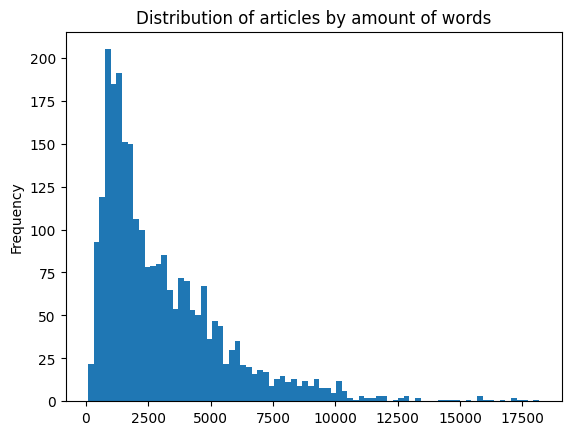

In [9]:
factiva2.body.str.len().plot.hist(bins = 80, title = 'Distribution of articles by amount of words')

<AxesSubplot:title={'center':'Distribution of articles over time'}, xlabel='date'>

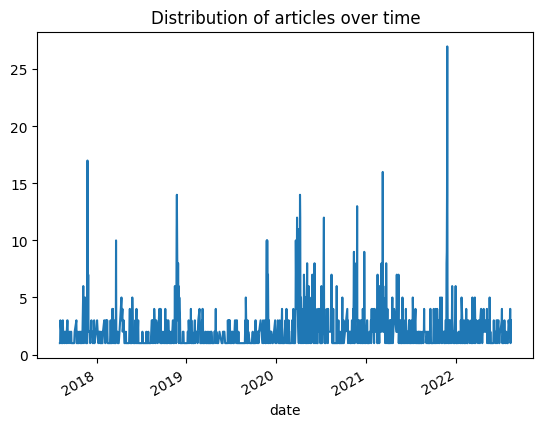

In [28]:
factiva2.groupby(pd.to_datetime(factiva2['date'], format='%d %B %Y')).size().plot(title = 'Distribution of articles over time')

In [10]:
print("Number of newspapers in this dataset:", factiva2['newspaper'].nunique(), "\n")
print("Number of articles by newspaper:\n", factiva2.groupby('newspaper').size().sort_values(ascending=False))

Number of newspapers in this dataset: 68 

Number of articles by newspaper:
 newspaper
Focus Online                                   332
Süddeutsche Zeitung                            162
Märkische Allgemeine Zeitung                   149
WELT online                                    119
Stuttgarter Zeitung                            119
Agence France Presse                           114
bild.de                                         99
Kölner Stadt-Anzeiger                           97
SDA - Schweizerische Depeschenagentur           85
Kurier Online                                   71
Basler Zeitung                                  66
Hamburger Abendblatt                            66
taz - die tageszeitung                          61
dpa-AFX ProFeed                                 58
ANSA Regional Service - Trentino Alto Adige     55
Neue Zürcher Zeitung                            47
Der Tagesspiegel                                46
AP Weltnachrichten                            

In [11]:
# Generalize duplicate newspapers: there are multiple labels per unique newspaper
# Sort all newspapers

newspaper_dict = { 
    "Focus": ["Focus Online"], 
    "Süddeutsche Zeitung": ["Süddeutsche Zeitung Online"],
    "Märkische Allgemeine": ["Märkische Allgemeine Zeitung"],
    "Kölner Stadtanzeiger": ["Kölner Stadt-Anzeiger"],
    "Kurier": ["Kurier Online"],
    "Basler Zeitung": ["Basler Zeitung Online"],
    "taz": ["taz - die tageszeitung", "taz.de"],
    "dpa": ["dpa-AFX ProFeed", "dpa-InfoLine"],
    "Der Tagesspiegel": ["Der Tagesspiegel Online"],
    "Tages Anzeiger": ["Tages Anzeiger Online"],
    "Hamburger Abendblatt": ["Hamburger Abendblatt Online"],
    "Frankfurter Rundschau": ["Frankfurter Rundschau Online"],
    "Berliner Morgenpost": ["Berliner Morgenpost Online"],
    "Deutsche Welle": ["DW Deutsch"],
    "Die Welt": ["Welt am Sonntag", "WELT online"],
    "NZZ am Sonntag": ["NZZ International"],
    "BILD": ["BILD Plus", "bild.de"], 
    "Kieler Nachrichten": ["Kieler Nachrichten Online", "Kieler Nachrichten/Segeberger Zeitung"],
    "Blick": ["Blick Online"], 
    "DIE ZEIT": ["ZEIT online", "ZEIT Österreich"],
    "Handelsblatt": ["Handelsblatt Online"], 
    "Stuttgarter Zeitung": ["Stuttgarter Zeitung"], 
    "Agence France Presse": ["Agence France Presse"],
    "SDA - Schweizerische Depeschenagentur": ["SDA - Schweizerische Depeschenagentur"],
    "ANSA Regional Service - Trentino Alto Adige": ["ANSA Regional Service - Trentino Alto Adige"],
    "Neue Zürcher Zeitung": ["Neue Zürcher Zeitung"],
    "AP Weltnachrichten": ["AP Weltnachrichten"],
    "Dow Jones Newswires German": ["Dow Jones Newswires German"],
    "Der Standard": ["Der Standard"],
    "Die Presse": ["Die Presse"],
    "Weser Kurier": ["Weser Kurier"],
    "Berliner Zeitung": ["Berliner Zeitung"],
    "Allgemeine Zeitung": ["Allgemeine Zeitung"],
    "General Anzeiger": ["General Anzeiger"],
    "Sächsische Zeitung": ["Sächsische Zeitung"],
    "Leipziger Volkszeitung": ["Leipziger Volkszeitung"],
    "Falter": ["Falter"],
    "Hannoversche Allgemeine Zeitung": ["Hannoversche Allgemeine Zeitung"],
    "Reuters": ["Reuters - Nachrichten auf Deutsch"],
    "Stern": ["Stern"],
    "Business Insider": ["Business Insider"],
    "Nürnberger Nachrichten": ["Nürnberger Nachrichten"],
    "Spiegel": ["Spiegel Online"]

}




In [12]:
# Store unique newspapers in a list

newspaper_general = []
for item in factiva2['newspaper']:
    for key, val in newspaper_dict.items():
        if item in val:
            newspaper_general.append(key)
            break
    else:
        newspaper_general.append(item)

# Check whether the length is correct
len(newspaper_general) == len(factiva2['newspaper'])

# Assign to new column
factiva2['newspaper_general'] =  newspaper_general

In [13]:
print("Number of newspapers in this dataset after sorting duplicate names:", factiva2['newspaper_general'].nunique(), "\n")
print("Number of articles by newspaper:\n", factiva2.groupby('newspaper_general').size().sort_values(ascending=False))

Number of newspapers in this dataset after sorting duplicate names: 43 

Number of articles by newspaper:
 newspaper_general
Focus                                          333
Süddeutsche Zeitung                            168
Märkische Allgemeine                           164
Die Welt                                       149
Stuttgarter Zeitung                            119
BILD                                           118
Agence France Presse                           114
Hamburger Abendblatt                           108
Kurier                                         101
Kölner Stadtanzeiger                            99
Der Tagesspiegel                                86
SDA - Schweizerische Depeschenagentur           85
taz                                             78
Tages Anzeiger                                  77
dpa                                             76
Basler Zeitung                                  69
Frankfurter Rundschau                           68
Berliner

In [43]:
print("Median number of DA articles per newspaper:", factiva2.groupby(['newspaper_general']).size().median())
print("Average number of DA articles per newspaper:", factiva2.groupby(['newspaper_general']).size().mean())

Median number of DA articles per newspaper: 36.0
Average number of DA articles per newspaper: 59.627906976744185


In [48]:
factiva2.newspaper_general.unique()

array(['Süddeutsche Zeitung', 'taz', 'Kurier', 'Frankfurter Rundschau',
       'Der Standard', 'Focus', 'Dow Jones Newswires German',
       'AP Weltnachrichten', 'Der Tagesspiegel', 'Berliner Morgenpost',
       'Märkische Allgemeine', 'BILD', 'Stuttgarter Zeitung', 'Die Welt',
       'Agence France Presse', 'SDA - Schweizerische Depeschenagentur',
       'Kölner Stadtanzeiger', 'Berliner Zeitung',
       'ANSA Regional Service - Trentino Alto Adige', 'Deutsche Welle',
       'Hamburger Abendblatt', 'Tages Anzeiger', 'Allgemeine Zeitung',
       'Neue Zürcher Zeitung', 'Die Presse', 'Basler Zeitung', 'DIE ZEIT',
       'dpa', 'NZZ am Sonntag', 'General Anzeiger', 'Sächsische Zeitung',
       'Leipziger Volkszeitung', 'Weser Kurier', 'Kieler Nachrichten',
       'Hannoversche Allgemeine Zeitung', 'Nürnberger Nachrichten',
       'Falter', 'Spiegel', 'Handelsblatt', 'Reuters', 'Stern',
       'Business Insider', 'Blick'], dtype=object)

In [35]:
# Check individual newspapers
#factiva2[factiva2['newspaper'] == "BILD Plus"]

In [63]:
# lowercase article body
factiva2["body"] = factiva2["body"].map(str.lower)

# visual check to see it works
print(factiva2["body"][14])

['Zwei Polizisten sind in Friedrichshain bei einem Einsatz wegen häuslicher Gewalt verletzt worden. Der betrunkene 55-Jährige stritt sich am Freitagabend mit seiner Partnerin in einer Wohnung an der Koppenstraße, so die Polizei am Sonnabend. Die Polizisten hörten die Hilfeschreie der Frau, weil die Wache in der Nachbarschaft liegt. Als sie den Mann zu Boden bringen und fesseln wollten, trat er einem Polizisten in den Rücken, der mehrere Blutergüsse erlitt. Ein Zweiter wurde am Knie verletzt']


In [15]:
# turn back to list for processing
title = factiva2['title'].tolist()
body = factiva2['body'].tolist()
date = factiva2['date'].tolist()
newspaper = factiva2['newspaper'].tolist()
newspaper_general = factiva2['newspaper_general'].tolist()

### Suggested edits for saving & loading data:

In [16]:
# Reformat to json
factiva_json = [{'title': a, 'body': b, 'date': c, 'newspaper': d, 'newspaper_general': e}
                for a, b, c, d, e in zip(title, body, date, newspaper, newspaper_general)]

# Check format: 
# 'title': XXX, 'body': XXX, 'date': XXX, 'newspaper': XXX, 'newspaper_general: XXX
factiva_json[1]


{'title': 'Gewalt gegen Frauen in den Medien; Gefährliche Lücke\n',
 'body': "['eine empirische studie analysiert berichterstattung über gewalt gegen frauen. sie zeigt: es dominieren einzelfälle statt struktureller probleme. von carolina schwarz', 'die silvesternacht 2015/2016 stellt eine zäsur für deutschland dar. gewaltbereite und meist betrunkene männer beschimpften, beklauten und belästigten sexuell in dieser nacht hunderte frauen auf dem platz vor dem kölner hauptbahnhof. es folgte eine wochenlange debatte , die letztlich dazu führte, dass das sexualstrafrecht verändert und das asylrecht eingeschränkt wurde. und auch für die deutsche medienlandschaft hatte das ereignis auswirkungen.', 'denn nach den vorfällen wurde kritik laut, medien hätten wegen „politischer korrektheit“ die herkünfte der mutmaßlichen täter zu lange geheim gehalten. diese wahrnehmung entspricht jedoch nicht der wahrheit . trotz allem formulierte der presserat im märz 2017 seine richtlinie zur herkunftsnennung um

In [16]:
# Export as json file
with open("data/factiva_data.json", 'w') as f:
    json.dump(factiva_json, f, indent=4)

# Old method: 
# factiva_export = [title, body, date, newspaper]
# with open("data/factiva_data.json", 'w') as f:
#   json.dump(factiva_export, f)

#### END OF CODE